# Deep Neural Networks Laboration

Data used in this laboration are from the Kitsune Network Attack Dataset, https://archive.ics.uci.edu/ml/datasets/Kitsune+Network+Attack+Dataset . We will focus on the 'Mirai' part of the dataset. Your task is to make a DNN that can classify if each attack is benign or malicious. The dataset has 116 covariates, but to make it a bit more difficult we will remove the first 24 covariates.

You need to answer all questions in this notebook.

If the training is too slow on your own computer, use the smaller datasets (*half or *quarter).

Dense networks are not optimal for tabular datasets like the one used here, but here the main goal is to learn deep learning.

# Part 1: Get the data

Skip this part if you load stored numpy arrays (Mirai*.npy) (which is recommended)

Use `wget` in the terminal of your cloud machine (in the same directory as where you have saved this notebook) to download the data, i.e.

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_dataset.csv.gz

wget https://archive.ics.uci.edu/ml/machine-learning-databases/00516/mirai/Mirai_labels.csv.gz

Then unpack the files using `gunzip` in the terminal, i.e.

gunzip Mirai_dataset.csv.gz

gunzip Mirai_labels.csv.gz

# Part 2: Get a graphics card

Skip this part if you run on the CPU (recommended)

Lets make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming calculations in every training iteration.

In [1]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

IndexError: list index out of range

# Part 3: Hardware

In deep learning, the computer hardware is very important. You should always know what kind of hardware you are working on. Lets pretend that everyone is using an Nvidia RTX 3090 graphics card.

Question 1: Google the name of the graphics card, how many CUDA cores does it have?

**Answer:**: 10496

Question 2: How much memory does the graphics card have?

**Answer:**: 24gb

Question 3: What is stored in the GPU memory while training a DNN ?

**Answer:**: It saves the forward calculations, partial derivatives, weights and the input data(coming from the batch and not the whole dataset). 


# Part 4: Load the data

To make this step easier, directly load the data from saved numpy arrays (.npy) (recommended)


Load the dataset from the csv files, it will take some time since it is almost 1.4 GB. (not recommended, unless you want to learn how to do it)

We will use the function `genfromtxt` to load the data. (not recommended, unless you want to learn how to do it)

https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html

Load the data from csv files the first time, then save the data as numpy files for faster loading the next time.

Remove the first 24 covariates to make the task harder.

In [2]:
from numpy import genfromtxt # Not needed if you load data from numpy arrays
import numpy as np

# Load data from numpy arrays, choose reduced files if the training takes too long
X = np.load('Mirai_data.npy')
Y = np.load('Mirai_labels.npy')

X = np.delete(X, np.s_[:24:], 1)
# Remove the first 24 covariates (columns)


print('The covariates have size {}.'.format(X.shape))
print('The labels have size {}.'.format(Y.shape))

# Print the number of examples of each class

The covariates have size (764137, 92).
The labels have size (764137,).


# Part 5: How good is a naive classifier?

Question 4: Given the number of examples from each class, how high classification performance can a naive classifier obtain? The naive classifier will assume that all examples belong to one class. Note: you do not need to make a naive classifier, this is a theoretical question, just to understand how good performance we can obtain by guessing that all examples belong to one class.

**Answer:** The highest claissification that a naive classifier can obtain given the number of examples from each class is the number of the samples of the class with the most samples devided by the total number of samples. In other words, the class with the highest percentage of samples. 

In all classification tasks you should always ask these questions

- How good classification accuracy can a naive classifier obtain? The naive classifier will assume that all examples belong to one class.
- What is random chance classification accuracy if you randomly guess the label of each (test) example? For a balanced dataset and binary classification this is easy (50%), but in many cases it is more complicated and a Monte Carlo simulation may be required to estimate random chance accuracy.

If your classifier cannot perform better than a naive classifier or a random classifier, you are doing something wrong.


In [3]:
# It is common to have NaNs in the data, lets check for it. Hint: np.isnan()


# Print the number of NaNs (not a number) in the labels
print(np.count_nonzero(np.isnan(Y)))

# Print the number of NaNs in the covariates
print(np.count_nonzero(np.isnan(X)))


0
0


# Part 6: Preprocessing

Lets do some simple preprocessing

In [4]:
# Convert covariates to floats
X = np.float64(X)

# Convert labels to integers
Y = np.int64(Y)

# Remove mean of each covariate (column)
column_means = np.mean(X, axis=0)
X = X - column_means

# Divide each covariate (column) by its standard deviation
column_stds = np.std(X, axis=0)
X = X / column_stds

# Check that mean is 0 and standard deviation is 1 for all covariates, by printing mean and std
print(np.mean(X, axis = 0)) # As you can see the values are not exactly zero but there are very small values which we can consider them zero. 
print(np.std(X, axis = 0))

[-3.19451533e-18 -6.32970181e-14  1.19926356e-13  4.56743018e-15
  4.10210037e-14  1.46130975e-13  5.85246484e-16 -1.69734859e-14
 -3.36915700e-13  1.28688437e-12 -2.69360995e-12 -1.10733213e-13
 -1.22392702e-13 -1.70649630e-13 -1.02461166e-14  2.50701280e-12
  1.47553162e-12  1.08446837e-12 -1.04981959e-13  6.83458762e-14
 -1.03373555e-13  5.98825773e-14 -1.02025960e-12 -1.68983055e-12
 -1.79101143e-12 -1.31828514e-13  4.42580403e-13  6.14635580e-13
  5.78048199e-14 -4.92623328e-13 -2.54513072e-12  1.86544900e-13
 -1.53444593e-13  1.68079591e-12  9.30041709e-13  1.50738177e-13
 -1.15688852e-12 -3.62610361e-13 -1.71390937e-12 -2.09264067e-13
  1.07161976e-12 -1.45236885e-12 -1.69724579e-14 -1.64918984e-16
 -5.13444996e-14 -1.02171349e-14 -1.74685907e-15  1.34264921e-13
  5.98801969e-14  1.48745574e-17 -4.25442340e-13  5.78079594e-14
  1.25638129e-15  1.69449684e-13  1.50725881e-13  2.14439542e-14
  3.65457183e-14  1.17260451e-13 -8.82752870e-13 -6.34816648e-13
 -1.62109649e-12  2.63270

# Part 7: Split the dataset

Use the first 70% of the dataset for training, leave the other 30% for validation and test, call the variables

Xtrain (70%)

Xtemp  (30%)

Ytrain (70%)

Ytemp  (30%)

We use a function from scikit learn.
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


In [5]:
from sklearn.model_selection import train_test_split

# Your code to split the dataset
Xtrain, Xtemp, Ytrain, Ytemp = train_test_split(X, Y, test_size=0.30, random_state=12345)

print('Xtrain has size {}.'.format(Xtrain.shape))
print('Ytrain has size {}.'.format(Ytrain.shape))

print('Xtemp has size {}.'.format(Xtemp.shape))
print('Ytemp has size {}.'.format(Ytemp.shape))

# Print the number of examples of each class, for the training data and the remaining 30%
print(f'The number of examples for the first class in the training data {sum(Ytrain == 0)}')
print(f'The number of examples for the second class in the training data {sum(Ytrain == 1)}')

print(f'The number of examples for the first class in the remaining data {sum(Ytemp == 0)}')
print(f'The number of examples for the second class in the remaining data {sum(Ytemp == 1)}')


Xtrain has size (534895, 92).
Ytrain has size (534895,).
Xtemp has size (229242, 92).
Ytemp has size (229242,).
The number of examples for the first class in the training data 85213
The number of examples for the second class in the training data 449682
The number of examples for the first class in the remaining data 36408
The number of examples for the second class in the remaining data 192834


#  Part 8: Split non-training data data into validation and test
Now split your non-training data (Xtemp, Ytemp) into 50% validation (Xval, Yval) and 50% testing (Xtest, Ytest), we use a function from scikit learn. In total this gives us 70% for training, 15% for validation, 15% for test.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Do all variables (Xtrain,Ytrain), (Xval,Yval), (Xtest,Ytest) have the shape that you expect?

In [6]:
from sklearn.model_selection import train_test_split

# Your code
Xval, Xtest, Yval, Ytest = train_test_split(Xtemp, Ytemp, test_size=0.50, random_state=12345)


print('The validation and test data have size {}, {}, {} and {}'.format(Xval.shape, Xtest.shape, Yval.shape, Ytest.shape))

The validation and test data have size (114621, 92), (114621, 92), (114621,) and (114621,)


# Part 9: DNN classification

Finish this code to create a first version of the classifier using a DNN. Start with a simple network with 2 dense layers (with 20 nodes each), using sigmoid activation functions. The final dense layer should have a single node and a sigmoid activation function. We start with the SGD optimizer.

For different parts of this notebook you need to go back here, add more things, and re-run this cell to re-define the build function.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

See https://keras.io/layers/core/ for information on how the `Dense()` function works

Import a relevant cost / loss function for binary classification from keras.losses (https://keras.io/losses/)

See the following links for how to compile, train and evaluate the model

https://keras.io/api/models/model_training_apis/#compile-method

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method

Make sure that the last layer always has a sigmoid activation function (why?).


In [7]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, BatchNormalization, Dropout
from keras.optimizers import SGD, Adam 
from keras.losses import BinaryCrossentropy

# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def build_DNN(input_shape, n_layers, n_nodes, act_fun='sigmoid', optimizer='sgd', learning_rate=0.01, 
              use_bn=False, use_dropout=False, use_custom_dropout=False):
    
    # Setup optimizer, depending on input parameter string
    if optimizer == "sgd":
        optim = SGD(learning_rate)
    
    elif optimizer == "adam":
         optim = Adam(learning_rate)
         
    # Setup a sequential model
    model = Sequential()

    # Add layers to the model, using the input parameters of the build_DNN function
    model.add(Input(shape=input_shape))

    # Add first layer, requires input shape
    model.add(Dense(n_nodes, activation=act_fun, input_dim=input_shape))

    if use_bn == True:
        model.add(BatchNormalization())

    if use_dropout == True:
        if use_custom_dropout == True:
            model.add(myDropout((Dropout(rate = 0.5))))
        else:
            model.add(Dropout(rate = 0.5))

    # Add remaining layers, do not require input shape
    for i in range(n_layers-1):
            model.add(Dense(n_nodes, activation=act_fun))
            if use_bn == True:
                model.add(BatchNormalization())
            
            if use_dropout == True:
                model.add(Dropout(rate = 0.5))
    
    # Add final layer
    model.add(Dense(1, activation='sigmoid'))
    if use_bn == True:
        model.add(BatchNormalization())

    # Compile model
    model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [8]:
# Lets define a help function for plotting the training results

import matplotlib.pyplot as plt
def plot_results(history):

    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

# Part 10: Train the DNN

Time to train the DNN, we start simple with 2 layers with 20 nodes each, learning rate 0.1.

Relevant functions

`build_DNN`, the function we defined in Part 9, call it with the parameters you want to use

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

See the following links for how to train and evaluate the model

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method


Make sure that you are using learning rate 0.1 !

### 2 layers, 20 nodes

In [9]:
# Setup some training parameters
batch_size = 10000
epochs = 20

input_shape = Xtrain.shape[1]

# Build the model
model1 = build_DNN(input_shape = input_shape, n_layers = 2, n_nodes = 20, learning_rate = 0.1)

# Train the model, provide training data and validation data
history1 = model1.fit(Xtrain, Ytrain, validation_data = (Xval, Yval),  epochs = epochs, batch_size = batch_size)

Epoch 1/20
54/54 [==============================] - 9s 134ms/step - loss: 0.4256 - accuracy: 0.8407 - val_loss: 0.3966 - val_accuracy: 0.8417
Epoch 2/20
54/54 [==============================] - 7s 122ms/step - loss: 0.3749 - accuracy: 0.8407 - val_loss: 0.3466 - val_accuracy: 0.8417
Epoch 3/20
54/54 [==============================] - 10s 191ms/step - loss: 0.3196 - accuracy: 0.8407 - val_loss: 0.2892 - val_accuracy: 0.8417
Epoch 4/20
54/54 [==============================] - 7s 121ms/step - loss: 0.2660 - accuracy: 0.8408 - val_loss: 0.2435 - val_accuracy: 0.8445
Epoch 5/20
54/54 [==============================] - 6s 111ms/step - loss: 0.2293 - accuracy: 0.8573 - val_loss: 0.2165 - val_accuracy: 0.8747
Epoch 6/20
54/54 [==============================] - 6s 110ms/step - loss: 0.2089 - accuracy: 0.8930 - val_loss: 0.2022 - val_accuracy: 0.9037
Epoch 7/20
54/54 [==============================] - 6s 105ms/step - loss: 0.1978 - accuracy: 0.9059 - val_loss: 0.1942 - val_accuracy: 0.9046
Epoch

In [10]:
# Evaluate the model on the test data
score = model1.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 23s 6ms/step - loss: 0.1720 - accuracy: 0.9083
Test loss: 0.1720
Test accuracy: 0.9083


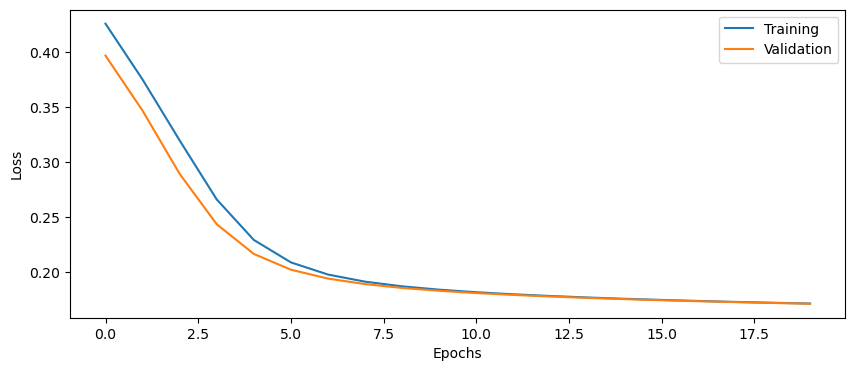

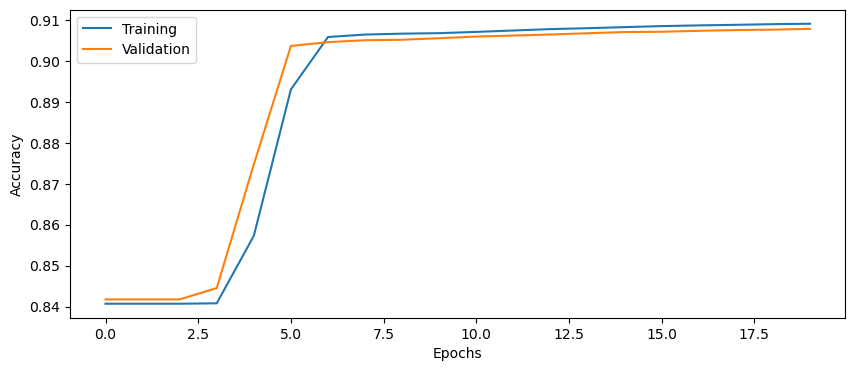

In [11]:
# Plot the history from the training run
plot_results(history1)

# Part 11: More questions

Question 5: What happens if you add several Dense layers without specifying the activation function?

**Answer**: It would use a linear activation function, which may take longer to converge and it may not fully seperate the classes.

Question 6: How are the weights in each dense layer initialized as default? How are the bias weights initialized?

**Answer**: According to the documentation all the weights are initialized as "glorot_uniform" and the bias weights are initialized as "zeros" (0). 
The glorot_uniform draws sample from uniform distribution [-limit, limit]. Whereas limit is defined as sqrt(6 / (fan_in + fan_out)). The fan_in is number of input units and fan_out is the number of output units.


# Part 12: Balancing the classes

This dataset is rather unbalanced, we need to define class weights so that the training pays more attention to the class with fewer samples. We use a function in scikit learn

https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

You need to call the function something like this

class_weights = class_weight.compute_class_weight(class_weight = , classes = , y = )

otherwise it will complain

In [12]:
from sklearn.utils import class_weight

# Calculate class weights

class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes = np.unique(Y), y = Y)

# Print the class weights
print(class_weights)

# Keras wants the weights in this form, uncomment and change value1 and value2 to your weights, 
# or get them from the array that is returned from class_weight

class_weights = {0: class_weights[0],
                 1: class_weights[1]}


[3.14146817 0.59464434]


### 2 layers, 20 nodes, class weights

In [14]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape[1]

# Build and train model
model2 = build_DNN(input_shape = input_shape, n_layers = 2, n_nodes = 20, learning_rate = 0.1)

history2 = model2.fit(Xtrain, Ytrain, validation_data = (Xval, Yval),  epochs = epochs, batch_size = batch_size, class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 9s 139ms/step - loss: 0.5958 - accuracy: 0.8761 - val_loss: 0.5151 - val_accuracy: 0.8833
Epoch 2/20
54/54 [==============================] - 6s 107ms/step - loss: 0.4057 - accuracy: 0.8834 - val_loss: 0.3567 - val_accuracy: 0.8820
Epoch 3/20
54/54 [==============================] - 6s 103ms/step - loss: 0.2845 - accuracy: 0.8841 - val_loss: 0.2953 - val_accuracy: 0.8843
Epoch 4/20
54/54 [==============================] - 7s 123ms/step - loss: 0.2404 - accuracy: 0.8869 - val_loss: 0.2758 - val_accuracy: 0.8868
Epoch 5/20
54/54 [==============================] - 5s 95ms/step - loss: 0.2229 - accuracy: 0.8892 - val_loss: 0.2666 - val_accuracy: 0.8890
Epoch 6/20
54/54 [==============================] - 8s 154ms/step - loss: 0.2137 - accuracy: 0.8909 - val_loss: 0.2586 - val_accuracy: 0.8908
Epoch 7/20
54/54 [==============================] - 6s 110ms/step - loss: 0.2079 - accuracy: 0.8927 - val_loss: 0.2549 - val_accuracy: 0.8927
Epoch 8

In [15]:
# Evaluate model on test data
score = model2.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 19s 5ms/step - loss: 0.2321 - accuracy: 0.9048
Test loss: 0.2321
Test accuracy: 0.9048


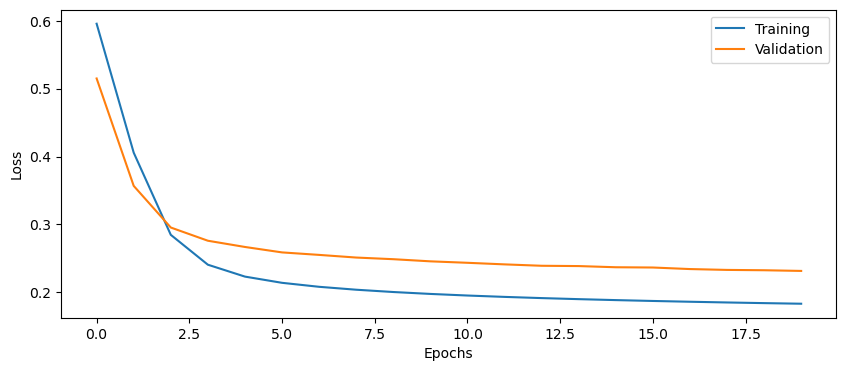

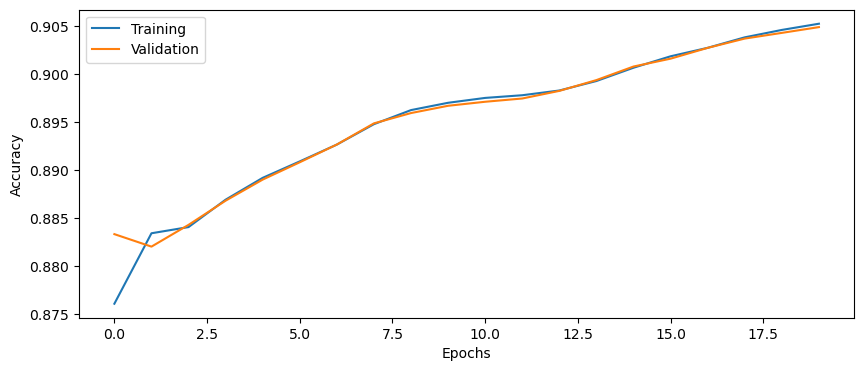

In [16]:
plot_results(history2)

# Part 13: More questions

Skip questions 8 and 9 if you run on the CPU (recommended)

Question 7: Why do we have to use a batch size? Why can't we simply use all data at once? This is more relevant for even larger datasets.

**Answer**: We use batch size because we cannot fit all data in GPU memory.

Question 8: How busy is the GPU for a batch size of 100? How much GPU memory is used? Hint: run 'nvidia-smi' on the computer a few times during training.

Question 9: What is the processing time for one training epoch when the batch size is 100? What is the processing time for one epoch when the batch size is 1,000? What is the processing time for one epoch when the batch size is 10,000? Explain the results. 

Question 10: How many times are the weights in the DNN updated in each training epoch if the batch size is 100? How many times are the weights in the DNN updated in each training epoch if the batch size is 1,000? How many times are the weights in the DNN updated in each training epoch if the batch size is 10,000?  

**Answer**:

Batchsize = 100: 534895/100 = 5349

Batchsize = 1000: 534895/1000 = 535

Batchsize = 10000: 534895/10000 = 54

**Important** If the resulting value is a float, then we have some remaining samples in the last batchsize. Therefore, we need to run 1 additional time.

Question 11: What limits how large the batch size can be?

**Answer**: It depends on the memory of the graphic card, as it is dependent on the memory.

Question 12: Generally speaking, how is the learning rate related to the batch size? If the batch size is decreased, how should the learning rate be changed?

**Answer**: Batch size and learning rate are closely related, with lower batch size we need lower learning rate and vice versa.

Lets use a batch size of 10,000 from now on, and a learning rate of 0.1.

# Part 14: Increasing the complexity

Lets try some different configurations of number of layers and number of nodes per layer.

Question 13: How many trainable parameters does the network with 4 dense layers with 50 nodes each have, compared to the initial network with 2 layers and 20 nodes per layer? Hint: use model.summary()

**Answer**: They can be found at the end of this part.

2 dense layers and 20 nodes: 2,301

4 dense layers and 50 nodes: 12,351

### 4 layers, 20 nodes, class weights

In [ ]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape[1]

# Build and train model
model3 = build_DNN(input_shape = input_shape, n_layers = 4, n_nodes = 20, learning_rate = 0.1)

history3 = model3.fit(Xtrain, Ytrain, validation_data = (Xval, Yval),  epochs = epochs, batch_size = batch_size, class_weight=class_weights)

Epoch 1/20
54/54 [==============================] - 5s 61ms/step - loss: 0.6959 - accuracy: 0.2429 - val_loss: 0.6921 - val_accuracy: 0.8441
Epoch 2/20
54/54 [==============================] - 2s 38ms/step - loss: 0.6933 - accuracy: 0.4717 - val_loss: 0.6939 - val_accuracy: 0.1634
Epoch 3/20
54/54 [==============================] - 2s 32ms/step - loss: 0.6927 - accuracy: 0.5175 - val_loss: 0.6930 - val_accuracy: 0.4642
Epoch 4/20
54/54 [==============================] - 2s 31ms/step - loss: 0.6920 - accuracy: 0.4913 - val_loss: 0.6923 - val_accuracy: 0.8771
Epoch 5/20
54/54 [==============================] - 2s 29ms/step - loss: 0.6912 - accuracy: 0.6559 - val_loss: 0.6889 - val_accuracy: 0.8612
Epoch 6/20
54/54 [==============================] - 2s 30ms/step - loss: 0.6902 - accuracy: 0.7917 - val_loss: 0.6851 - val_accuracy: 0.8607
Epoch 7/20
54/54 [==============================] - 2s 35ms/step - loss: 0.6889 - accuracy: 0.8161 - val_loss: 0.6885 - val_accuracy: 0.8869
Epoch 8/20
54

In [ ]:
# Evaluate model on test data
score = model3.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 9s 2ms/step - loss: 0.2801 - accuracy: 0.8799
Test loss: 0.2801
Test accuracy: 0.8799


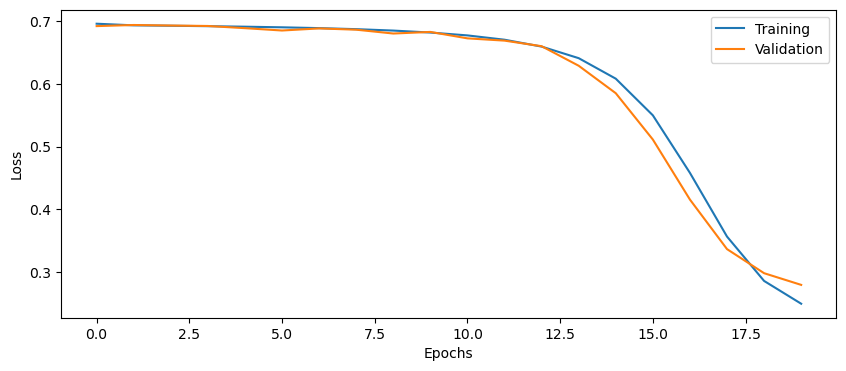

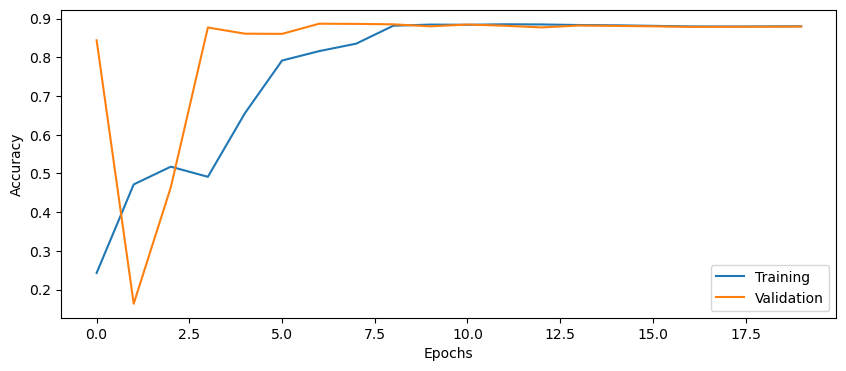

In [ ]:
plot_results(history3)

### 2 layers, 50 nodes, class weights

In [ ]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape[1]

# Build and train model
model4 = build_DNN(input_shape = input_shape, n_layers = 2, n_nodes = 50, learning_rate = 0.1)

history4 = model4.fit(Xtrain, Ytrain, validation_data = (Xval, Yval),  epochs = epochs, batch_size = batch_size, class_weight=class_weights)


Epoch 1/20
54/54 [==============================] - 3s 35ms/step - loss: 0.6193 - accuracy: 0.8307 - val_loss: 0.5281 - val_accuracy: 0.8903
Epoch 2/20
54/54 [==============================] - 1s 23ms/step - loss: 0.4287 - accuracy: 0.8850 - val_loss: 0.3494 - val_accuracy: 0.8830
Epoch 3/20
54/54 [==============================] - 1s 22ms/step - loss: 0.2838 - accuracy: 0.8842 - val_loss: 0.2857 - val_accuracy: 0.8848
Epoch 4/20
54/54 [==============================] - 1s 22ms/step - loss: 0.2359 - accuracy: 0.8871 - val_loss: 0.2697 - val_accuracy: 0.8874
Epoch 5/20
54/54 [==============================] - 1s 21ms/step - loss: 0.2196 - accuracy: 0.8908 - val_loss: 0.2621 - val_accuracy: 0.8915
Epoch 6/20
54/54 [==============================] - 2s 35ms/step - loss: 0.2116 - accuracy: 0.8936 - val_loss: 0.2576 - val_accuracy: 0.8941
Epoch 7/20
54/54 [==============================] - 1s 27ms/step - loss: 0.2065 - accuracy: 0.8958 - val_loss: 0.2541 - val_accuracy: 0.8957
Epoch 8/20
54

In [ ]:
# Evaluate model on test data
score = model4.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 11s 3ms/step - loss: 0.2323 - accuracy: 0.9036
Test loss: 0.2323
Test accuracy: 0.9036


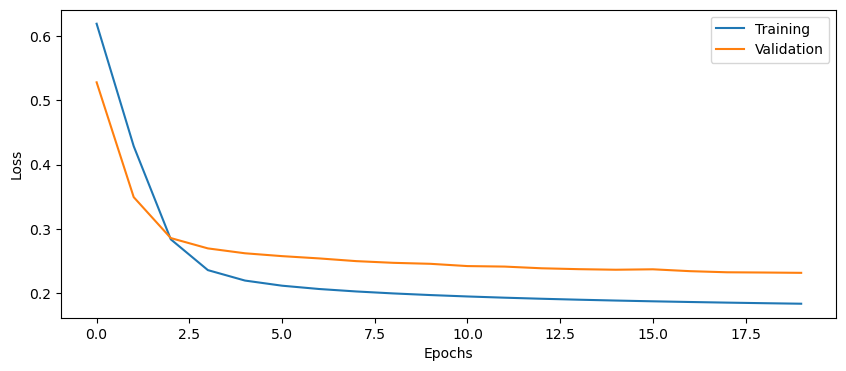

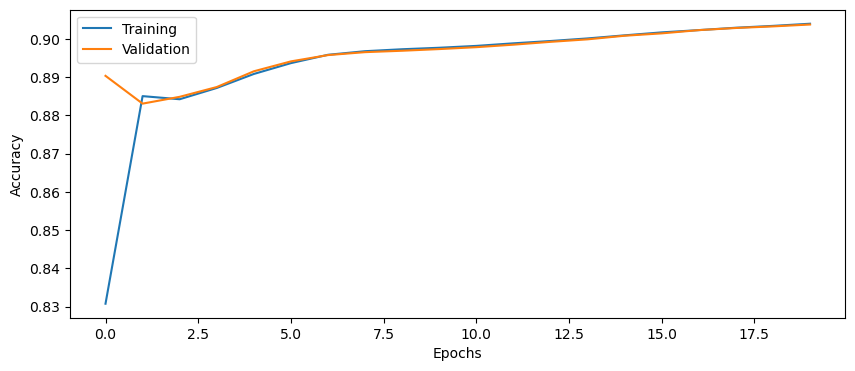

In [ ]:
plot_results(history4)

### 4 layers, 50 nodes, class weights

In [17]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape[1]


# Build and train model
model5 = build_DNN(input_shape = input_shape, n_layers = 4, n_nodes = 50, learning_rate = 0.1)

history5 = model5.fit(Xtrain, Ytrain, validation_data = (Xval, Yval),  epochs = epochs, batch_size = batch_size, class_weight=class_weights)


Epoch 1/20
54/54 [==============================] - 10s 149ms/step - loss: 0.6929 - accuracy: 0.4966 - val_loss: 0.6946 - val_accuracy: 0.1711
Epoch 2/20
54/54 [==============================] - 17s 317ms/step - loss: 0.6918 - accuracy: 0.5895 - val_loss: 0.6995 - val_accuracy: 0.1583
Epoch 3/20
54/54 [==============================] - 8s 145ms/step - loss: 0.6906 - accuracy: 0.6121 - val_loss: 0.6937 - val_accuracy: 0.1965
Epoch 4/20
54/54 [==============================] - 7s 122ms/step - loss: 0.6890 - accuracy: 0.7254 - val_loss: 0.6873 - val_accuracy: 0.8754
Epoch 5/20
54/54 [==============================] - 9s 169ms/step - loss: 0.6870 - accuracy: 0.8076 - val_loss: 0.6892 - val_accuracy: 0.8784
Epoch 6/20
54/54 [==============================] - 7s 138ms/step - loss: 0.6842 - accuracy: 0.8659 - val_loss: 0.6997 - val_accuracy: 0.1586
Epoch 7/20
54/54 [==============================] - 9s 159ms/step - loss: 0.6802 - accuracy: 0.8642 - val_loss: 0.6778 - val_accuracy: 0.8752
Epoc

In [18]:
# Evaluate model on test data
score = model5.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 27s 7ms/step - loss: 0.2617 - accuracy: 0.8841
Test loss: 0.2617
Test accuracy: 0.8841


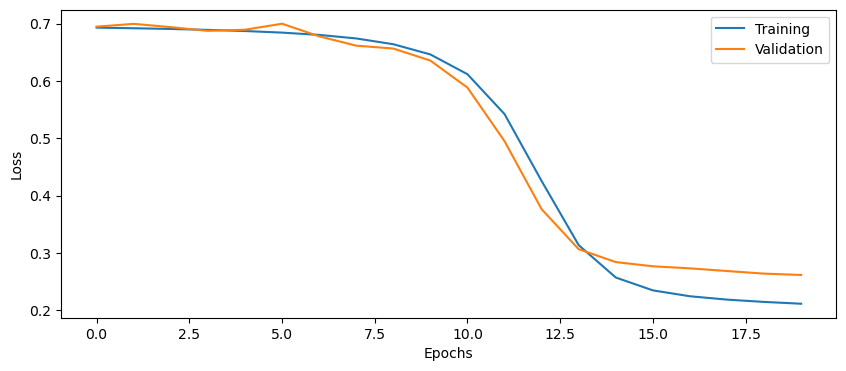

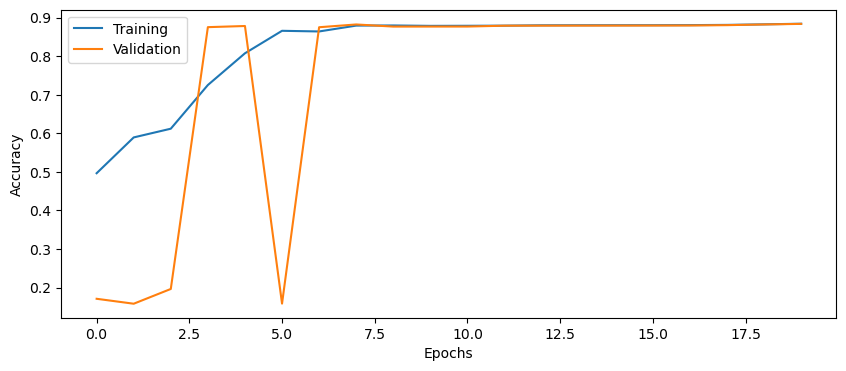

In [19]:
plot_results(history5)

In [20]:
print(model2.summary())
print(model5.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 20)                1860      
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,301
Trainable params: 2,301
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 50)                4650      
                                                                 
 dense_7 (Dense)         

# Part 15: Batch normalization

Now add batch normalization after each dense layer in `build_DNN`. Remember to import BatchNormalization from keras.layers. 

See https://keras.io/layers/normalization/ for information about how to call the function.

Question 14: Why is batch normalization important when training deep networks?

**Answer**: According to lecture 2, slide 56 "Normalizing the input makes optimization easier, since the loss function behaves nicer (more isotropic)".

### 2 layers, 20 nodes, class weights, batch normalization

In [ ]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape[1]

# Build and train model
model6 = build_DNN(input_shape = input_shape, n_layers = 2, n_nodes = 20, learning_rate = 0.1, use_bn=True)


history6 = model6.fit(Xtrain, Ytrain, validation_data = (Xval, Yval),  epochs = epochs, batch_size = batch_size, class_weight=class_weights)


Epoch 1/20
54/54 [==============================] - 6s 51ms/step - loss: 1.2419 - accuracy: 0.8640 - val_loss: 0.6798 - val_accuracy: 0.8563
Epoch 2/20
54/54 [==============================] - 6s 108ms/step - loss: 1.1020 - accuracy: 0.8798 - val_loss: 2.3301 - val_accuracy: 0.6923
Epoch 3/20
54/54 [==============================] - 4s 66ms/step - loss: 1.1044 - accuracy: 0.8798 - val_loss: 2.2073 - val_accuracy: 0.8639
Epoch 4/20
54/54 [==============================] - 2s 41ms/step - loss: 1.1005 - accuracy: 0.8799 - val_loss: 2.0701 - val_accuracy: 0.8730
Epoch 5/20
54/54 [==============================] - 2s 29ms/step - loss: 1.0997 - accuracy: 0.8799 - val_loss: 1.9752 - val_accuracy: 0.8765
Epoch 6/20
54/54 [==============================] - 2s 31ms/step - loss: 1.0991 - accuracy: 0.8799 - val_loss: 1.9092 - val_accuracy: 0.8781
Epoch 7/20
54/54 [==============================] - 2s 36ms/step - loss: 1.0971 - accuracy: 0.8800 - val_loss: 1.9126 - val_accuracy: 0.8788
Epoch 8/20
5

In [ ]:
# Evaluate model on test data
score = model6.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 11s 3ms/step - loss: 2.4306 - accuracy: 0.8406
Test loss: 2.4306
Test accuracy: 0.8406


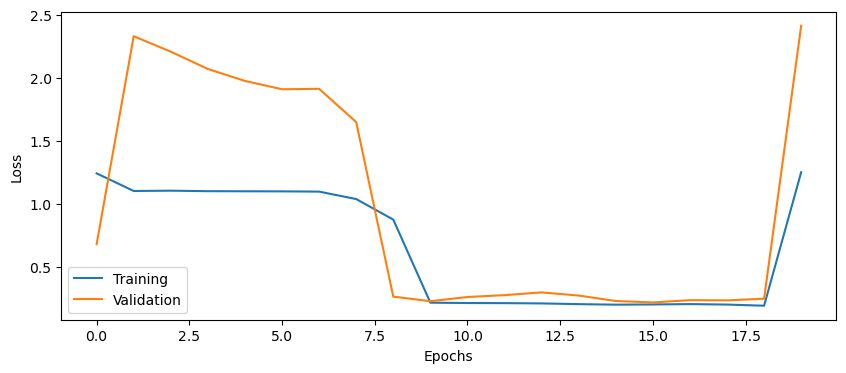

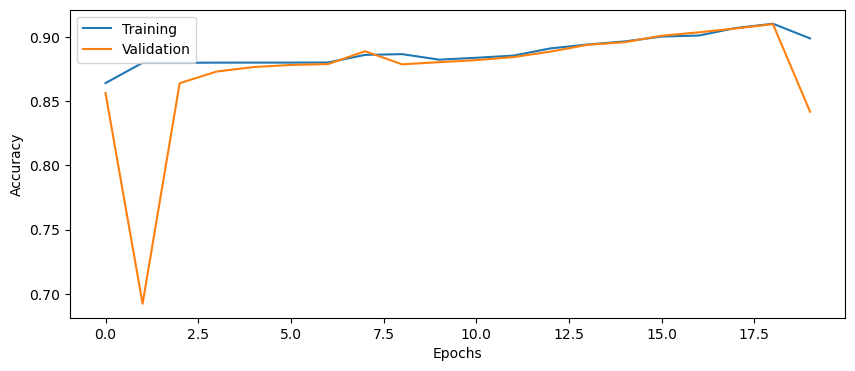

In [ ]:
plot_results(history6)

# Part 16: Activation function

Try changing the activation function in each layer from sigmoid to ReLU, write down the test accuracy.

Note: the last layer should still have a sigmoid activation function.

https://keras.io/api/layers/activations/

### 2 layers, 20 nodes, class weights, ReLU, no batch normalization

In [ ]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape[1]

# Build and train model
model7 = build_DNN(input_shape = input_shape, n_layers = 2, n_nodes = 20, learning_rate = 0.1, act_fun='relu')

history7 = model7.fit(Xtrain, Ytrain, validation_data = (Xval, Yval),  epochs = epochs, batch_size = batch_size, class_weight=class_weights)


Epoch 1/20
54/54 [==============================] - 3s 32ms/step - loss: 0.2906 - accuracy: 0.8813 - val_loss: 0.2660 - val_accuracy: 0.8925
Epoch 2/20
54/54 [==============================] - 2s 29ms/step - loss: 0.2003 - accuracy: 0.8969 - val_loss: 0.2391 - val_accuracy: 0.9001
Epoch 3/20
54/54 [==============================] - 1s 19ms/step - loss: 0.1872 - accuracy: 0.9033 - val_loss: 0.2343 - val_accuracy: 0.9056
Epoch 4/20
54/54 [==============================] - 1s 21ms/step - loss: 0.1809 - accuracy: 0.9070 - val_loss: 0.2300 - val_accuracy: 0.9077
Epoch 5/20
54/54 [==============================] - 1s 18ms/step - loss: 0.1769 - accuracy: 0.9089 - val_loss: 0.2246 - val_accuracy: 0.9097
Epoch 6/20
54/54 [==============================] - 2s 45ms/step - loss: 0.1742 - accuracy: 0.9119 - val_loss: 0.2181 - val_accuracy: 0.9130
Epoch 7/20
54/54 [==============================] - 3s 47ms/step - loss: 0.1721 - accuracy: 0.9136 - val_loss: 0.2186 - val_accuracy: 0.9137
Epoch 8/20
54

In [ ]:
# Evaluate model on test data
score = model7.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 8s 2ms/step - loss: 0.2096 - accuracy: 0.9154
Test loss: 0.2096
Test accuracy: 0.9154


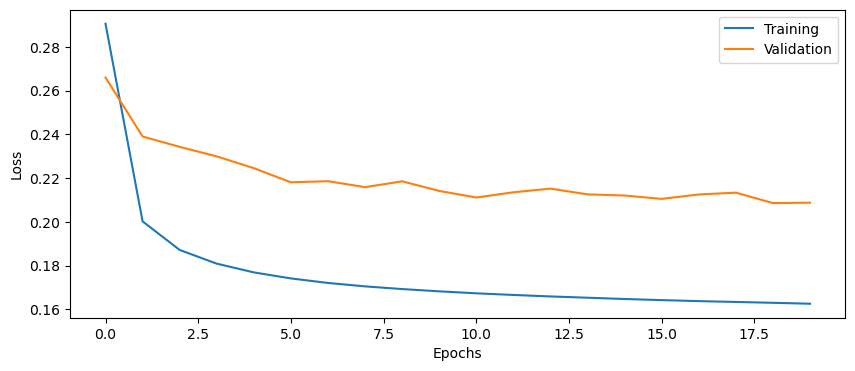

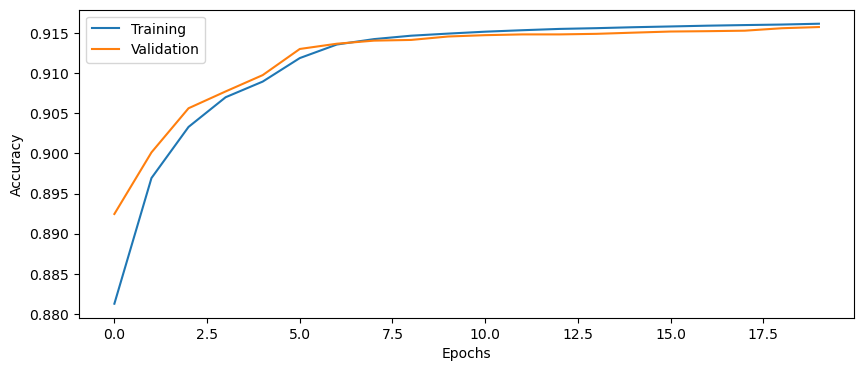

In [ ]:
plot_results(history7)

# Part 17: Optimizer

Try changing the optimizer from SGD to Adam (with learning rate 0.1 as before). Remember to import the Adam optimizer from keras.optimizers. 

https://keras.io/optimizers/


### 2 layers, 20 nodes, class weights, Adam optimizer, no batch normalization, sigmoid activations

In [ ]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape[1]

# Build and train model
model8 = build_DNN(input_shape = input_shape, n_layers = 2, n_nodes = 20, learning_rate = 0.1, optimizer="adam")

history8 = model8.fit(Xtrain, Ytrain, validation_data = (Xval, Yval),  epochs = epochs, batch_size = batch_size, class_weight=class_weights)


Epoch 1/20
54/54 [==============================] - 4s 48ms/step - loss: 0.2314 - accuracy: 0.8832 - val_loss: 0.2275 - val_accuracy: 0.9121
Epoch 2/20
54/54 [==============================] - 1s 23ms/step - loss: 0.1694 - accuracy: 0.9143 - val_loss: 0.2139 - val_accuracy: 0.9155
Epoch 3/20
54/54 [==============================] - 1s 19ms/step - loss: 0.1647 - accuracy: 0.9169 - val_loss: 0.2185 - val_accuracy: 0.9166
Epoch 4/20
54/54 [==============================] - 1s 19ms/step - loss: 0.1615 - accuracy: 0.9175 - val_loss: 0.2028 - val_accuracy: 0.9185
Epoch 5/20
54/54 [==============================] - 1s 23ms/step - loss: 0.1581 - accuracy: 0.9192 - val_loss: 0.2002 - val_accuracy: 0.9183
Epoch 6/20
54/54 [==============================] - 1s 20ms/step - loss: 0.1563 - accuracy: 0.9200 - val_loss: 0.2132 - val_accuracy: 0.9192
Epoch 7/20
54/54 [==============================] - 1s 24ms/step - loss: 0.1531 - accuracy: 0.9203 - val_loss: 0.1844 - val_accuracy: 0.9203
Epoch 8/20
54

In [ ]:
# Evaluate model on test data
score = model8.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 11s 3ms/step - loss: 0.1657 - accuracy: 0.9323
Test loss: 0.1657
Test accuracy: 0.9323


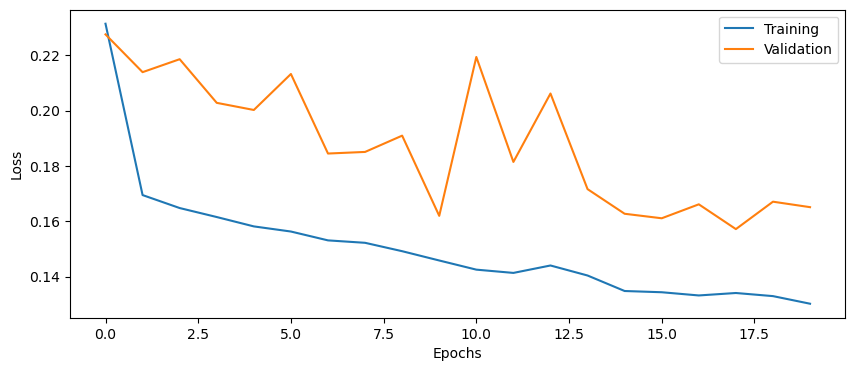

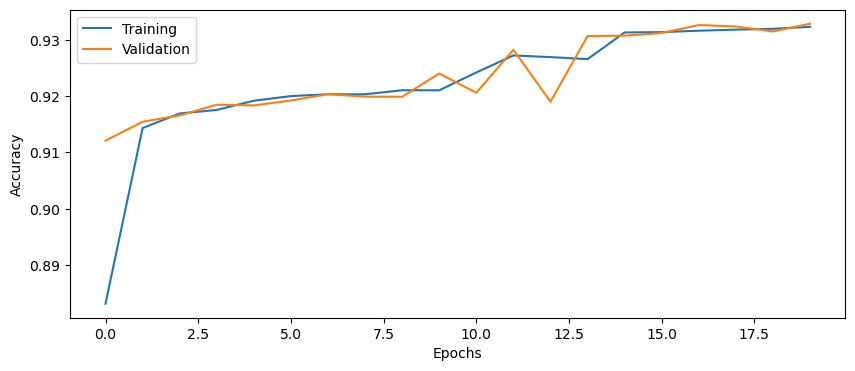

In [ ]:
plot_results(history8)

# Part 18: Dropout regularization

Dropout is a type of regularization that can improve accuracy for validation and test data. It randomly removes connections to force the neural network to not rely too much on a small number of weights.

Add a Dropout layer after each Dense layer (but not after the final dense layer) in `build_DNN`, with a dropout probability of 50%. Remember to first import the Dropout layer from keras.layers

See https://keras.io/api/layers/regularization_layers/dropout/ for how the Dropout layer works.

---

Question 15: How does the validation accuracy change when adding dropout?

**Answer**: With comparison to the model in Part 14, with the same hyperparameters but without dropout, the validation accuracy decreased from 0.9016 to 0.8807. 


Question 16: How does the test accuracy change when adding dropout?

**Answer**: With comparison to the model in Part 14, with the same hyperparameters but without dropout, the test accuracy decreased from 0.9013 to 0.8808. 

### 2 layers, 20 nodes, class weights, dropout, SGD optimizer, no batch normalization, sigmoid activations

In [ ]:
# Setup some training parameters
batch_size = 10000
epochs = 20
input_shape = Xtrain.shape[1]

# Build and train model
model9 = build_DNN(input_shape = input_shape, n_layers = 2, n_nodes = 20, learning_rate = 0.1, use_dropout=True)

history9 = model9.fit(Xtrain, Ytrain, validation_data = (Xval, Yval),  epochs = epochs, batch_size = batch_size, class_weight=class_weights)


Epoch 1/20
54/54 [==============================] - 7s 73ms/step - loss: 0.7090 - accuracy: 0.5506 - val_loss: 0.6221 - val_accuracy: 0.8877
Epoch 2/20
54/54 [==============================] - 2s 28ms/step - loss: 0.6385 - accuracy: 0.6356 - val_loss: 0.5535 - val_accuracy: 0.8801
Epoch 3/20
54/54 [==============================] - 2s 29ms/step - loss: 0.5688 - accuracy: 0.7179 - val_loss: 0.4643 - val_accuracy: 0.8782
Epoch 4/20
54/54 [==============================] - 2s 28ms/step - loss: 0.5005 - accuracy: 0.7739 - val_loss: 0.3853 - val_accuracy: 0.8780
Epoch 5/20
54/54 [==============================] - 2s 35ms/step - loss: 0.4408 - accuracy: 0.8102 - val_loss: 0.3309 - val_accuracy: 0.8782
Epoch 6/20
54/54 [==============================] - 2s 31ms/step - loss: 0.3987 - accuracy: 0.8322 - val_loss: 0.3059 - val_accuracy: 0.8785
Epoch 7/20
54/54 [==============================] - 2s 35ms/step - loss: 0.3706 - accuracy: 0.8438 - val_loss: 0.2936 - val_accuracy: 0.8789
Epoch 8/20
54

In [ ]:
# Evaluate model on test data
score = model9.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 9s 2ms/step - loss: 0.2691 - accuracy: 0.8808
Test loss: 0.2691
Test accuracy: 0.8808


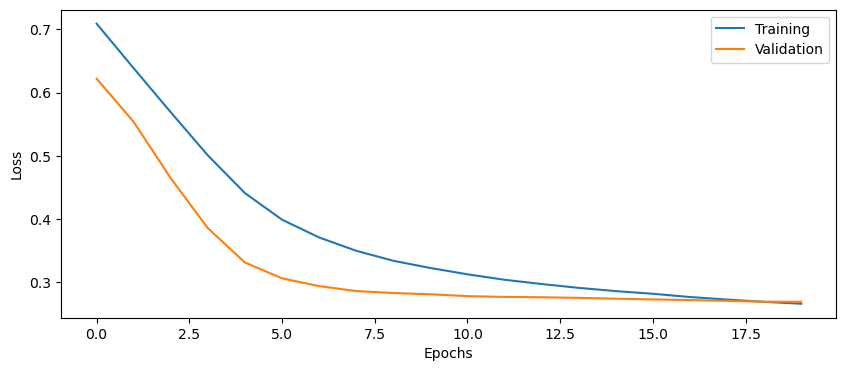

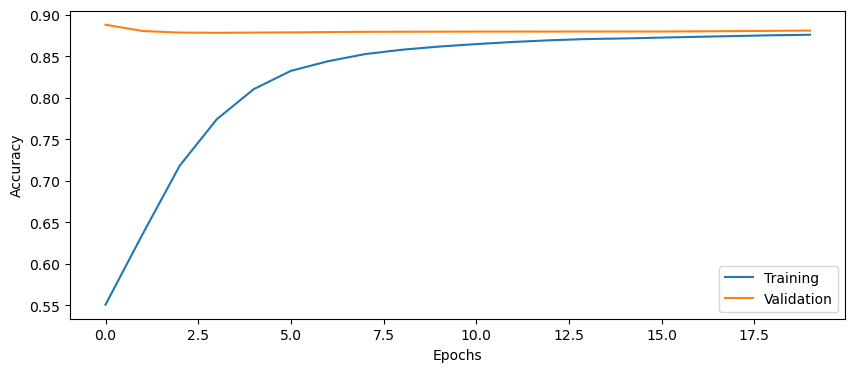

In [ ]:
plot_results(history9)

# Part 19: Improving performance

Spend some time (30 - 90 minutes) playing with the network architecture (number of layers, number of nodes per layer, activation function) and other hyper parameters (optimizer, learning rate, batch size, number of epochs, degree of regularization). For example, try a much deeper network. How much does the training time increase for a network with 10 layers?

Question 17: How high classification accuracy can you achieve for the test data? What is your best configuration?

**Answer**: After 14 experiments (https://docs.google.com/spreadsheets/d/1sljfcFphZPJKZbHc19a1dKtlMf8nyUMQYT_WXTJHmMg/edit?usp=sharing), the best results were test validation = 0.9377. 

With following configurations: Batchsize = 1000, Epochs= 40, n_layers= 4, n_nodes= 40, learning =0.01, activation function = sigmod, Optimizer = Adam, Weights=True, Dropout = False, Batch Normalization = False.


In [24]:
# Find your best configuration for the DNN

batch_size = 1000
epochs = 40
# Build and train DNN
model10 = build_DNN(input_shape = input_shape, n_layers = 4, n_nodes = 40, learning_rate = 0.01, optimizer='adam')

history10 = model10.fit(Xtrain, Ytrain, validation_data = (Xval, Yval),  epochs = epochs, batch_size = batch_size, class_weight=class_weights)


Epoch 1/40
535/535 [==============================] - 6s 8ms/step - loss: 0.1902 - accuracy: 0.9046 - val_loss: 0.2110 - val_accuracy: 0.9173
Epoch 2/40
535/535 [==============================] - 4s 7ms/step - loss: 0.1555 - accuracy: 0.9194 - val_loss: 0.1737 - val_accuracy: 0.9223
Epoch 3/40
535/535 [==============================] - 5s 8ms/step - loss: 0.1432 - accuracy: 0.9262 - val_loss: 0.1787 - val_accuracy: 0.9286
Epoch 4/40
535/535 [==============================] - 4s 7ms/step - loss: 0.1356 - accuracy: 0.9305 - val_loss: 0.1869 - val_accuracy: 0.9284
Epoch 5/40
535/535 [==============================] - 4s 7ms/step - loss: 0.1316 - accuracy: 0.9324 - val_loss: 0.1765 - val_accuracy: 0.9322
Epoch 6/40
535/535 [==============================] - 6s 11ms/step - loss: 0.1298 - accuracy: 0.9332 - val_loss: 0.1785 - val_accuracy: 0.9309
Epoch 7/40
535/535 [==============================] - 5s 10ms/step - loss: 0.1269 - accuracy: 0.9341 - val_loss: 0.1682 - val_accuracy: 0.9335
Epoc

In [25]:
# Evaluate DNN on test data
score = model10.evaluate(Xtest, Ytest)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 10s 3ms/step - loss: 0.1643 - accuracy: 0.9350
Test loss: 0.1643
Test accuracy: 0.9350


In [ ]:
#Relu, n_layers = 4, n_nodes = 20, sgd = adam, weights
model10 = build_DNN(input_shape = input_shape, n_layers = 4, n_nodes = 20, learning_rate = 0.1, act_fun='relu', optimizer='adam')
history10 = model10.fit(Xtrain, Ytrain, validation_data = (Xval, Yval),  epochs = epochs, batch_size = batch_size, class_weight=class_weights)
# : 0.9180


# Part 20: Dropout uncertainty

Dropout can also be used during testing, to obtain an estimate of the model uncertainty. Since dropout will randomly remove connections, the network will produce different results every time the same (test) data is put into the network. This technique is called Monte Carlo dropout. For more information, see this paper http://proceedings.mlr.press/v48/gal16.pdf

To achieve this, we need to redefine the Keras Dropout call by running the cell below, and use 'myDropout' in each call to Dropout, in the cell that defines the DNN. The `build_DNN` function takes two boolean arguments, use_dropout and use_custom_dropout, add a standard Dropout layer if use_dropout is true, add a myDropout layer if use_custom_dropout is true.

Run the same test data through the trained network 100 times, with dropout turned on. 

Question 18: What is the mean and the standard deviation of the test accuracy?

**Answer**:

Mean : 0.93876

Standard deviation : 0.0

In [11]:
import keras.backend as K
import keras

class myDropout(keras.layers.Dropout):
    """Applies Dropout to the input.
    Dropout consists in randomly setting
    a fraction `rate` of input units to 0 at each update during training time,
    which helps prevent overfitting.
    # Arguments
        rate: float between 0 and 1. Fraction of the input units to drop.
        noise_shape: 1D integer tensor representing the shape of the
            binary dropout mask that will be multiplied with the input.
            For instance, if your inputs have shape
            `(batch_size, timesteps, features)` and
            you want the dropout mask to be the same for all timesteps,
            you can use `noise_shape=(batch_size, 1, features)`.
        seed: A Python integer to use as random seed.
    # References
        - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](
           http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
    """
    def __init__(self, rate, training=True, noise_shape=None, seed=None, **kwargs):
        super(myDropout, self).__init__(rate, noise_shape=None, seed=None,**kwargs)
        self.training = training

        
    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape,
                                 seed=self.seed)
            if not training: 
                return K.in_train_phase(dropped_inputs, inputs, training=self.training)
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        return inputs

### Your best config, custom dropout

In [31]:
# Your best training parameters
epochs = 100
batch_size = 1000

# Build and train model
model11 = build_DNN(input_shape = input_shape, n_layers = 4, n_nodes = 40, learning_rate = 0.01, optimizer='adam', use_custom_dropout=True)

history11 = model11.fit(Xtrain, Ytrain, validation_data = (Xval, Yval),  epochs = epochs, batch_size = batch_size, class_weight=class_weights)


Epoch 1/100
535/535 [==============================] - 6s 7ms/step - loss: 0.1833 - accuracy: 0.9067 - val_loss: 0.1774 - val_accuracy: 0.9177
Epoch 2/100
535/535 [==============================] - 4s 7ms/step - loss: 0.1556 - accuracy: 0.9190 - val_loss: 0.2132 - val_accuracy: 0.9189
Epoch 3/100
535/535 [==============================] - 6s 11ms/step - loss: 0.1450 - accuracy: 0.9245 - val_loss: 0.2095 - val_accuracy: 0.9259
Epoch 4/100
535/535 [==============================] - 4s 7ms/step - loss: 0.1380 - accuracy: 0.9286 - val_loss: 0.1741 - val_accuracy: 0.9305
Epoch 5/100
535/535 [==============================] - 5s 10ms/step - loss: 0.1330 - accuracy: 0.9311 - val_loss: 0.1691 - val_accuracy: 0.9327
Epoch 6/100
535/535 [==============================] - 4s 8ms/step - loss: 0.1302 - accuracy: 0.9322 - val_loss: 0.1701 - val_accuracy: 0.9317
Epoch 7/100
535/535 [==============================] - 5s 9ms/step - loss: 0.1289 - accuracy: 0.9325 - val_loss: 0.1383 - val_accuracy: 0.93

In [32]:
# Run this cell a few times to evalute the model on test data, 
# if you get slightly different test accuracy every time, Dropout during testing is working

# Evaluate model on test data
score = model11.evaluate(Xtest, Ytest)
                       
print('Test accuracy: %.4f' % score[1])

3582/3582 [==============================] - 11s 3ms/step - loss: 0.1293 - accuracy: 0.9388
Test accuracy: 0.9388


In [37]:
import statistics as stat
# Run the testing 100 times, and save the accuracies in an array
test_accuracy = []

for iteration in range(100):
    test_accuracy.append(model11.evaluate(Xtest, Ytest)[1])
    


3582/3582 [==============================] - 9s 3ms/step - loss: 0.1293 - accuracy: 0.9388
0.9387633800506592
0.0


In [38]:
# Calculate and print mean and std of accuracies
print(stat.mean(test_accuracy))
print(stat.stdev(test_accuracy))

0.9387633800506592
0.0


# Part 21: Cross validation uncertainty

Cross validation (CV) is often used to evaluate a model, by training and testing using different subsets of the data it is possible to get the uncertainty as the standard deviation over folds. We here use a help function from scikit-learn to setup the CV, see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html . Use 10 folds with shuffling, random state 1234. 

Note: We here assume that you have found the best hyper parameters, so here the data are only split into training and testing, no validation.

---

Question 19: What is the mean and the standard deviation of the test accuracy?

**Answer**:

Mean: 0.9178982257843018

Standard deviation : 0.0014277604992352548


Question 20: What is the main advantage of dropout compared to CV for estimating test uncertainty? The difference may not be so large in this notebook, but imagine that you have a network that takes 24 hours to train.

**Answer**: Dropout is much faster as in each iteration it doesn't train some neurons(based on the dropout rate) and after each iteration we have a new model which we can evaluate, while CV has to fit many different models and it splits the training dataset, so it's much more time consuming.

In [22]:
from sklearn.model_selection import StratifiedKFold

# Define 10-fold cross validation
skf = StratifiedKFold(n_splits=10, random_state=1234, shuffle=True)

results = []

epochs = 20
batch_size = 100000

# Loop over cross validation folds
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):

    # Calculate class weights for current split
    class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes = np.unique(Y), y = Y[train_index])
    
    class_weights = {0: class_weights[0],
                 1: class_weights[1]}

    # Rebuild the DNN model, to not continue training on the previously trained model
    model12 = build_DNN(input_shape = input_shape, n_layers = 4, n_nodes = 40, learning_rate = 0.01, optimizer='adam')    
    
    # Fit the model with training set and class weights for this fold
    history12 = model12.fit(X[train_index], Y[train_index], validation_data = False,  epochs = epochs, batch_size = batch_size, class_weight=class_weights)
    
    # Evaluate the model using the test set for this fold
    score = model12.evaluate(X[test_index], Y[test_index])
    
    # Save the test accuracy in an array
    results.append(score[1]) 

# Calculate and print mean and std of accuracies
print(stat.mean(results))
print(stat.stdev(results))


Epoch 1/20
7/7 [==============================] - 6s 615ms/step - loss: 0.7139 - accuracy: 0.3573
Epoch 2/20
7/7 [==============================] - 3s 374ms/step - loss: 0.6130 - accuracy: 0.8602
Epoch 3/20
7/7 [==============================] - 3s 494ms/step - loss: 0.3796 - accuracy: 0.8791
Epoch 4/20
7/7 [==============================] - 3s 387ms/step - loss: 0.2403 - accuracy: 0.8800
Epoch 5/20
7/7 [==============================] - 3s 428ms/step - loss: 0.2174 - accuracy: 0.8823
Epoch 6/20
7/7 [==============================] - 3s 458ms/step - loss: 0.2045 - accuracy: 0.8902
Epoch 7/20
7/7 [==============================] - 3s 474ms/step - loss: 0.1960 - accuracy: 0.8963
Epoch 8/20
7/7 [==============================] - 4s 524ms/step - loss: 0.1905 - accuracy: 0.9009
Epoch 9/20
7/7 [==============================] - 3s 446ms/step - loss: 0.1842 - accuracy: 0.9040
Epoch 10/20
7/7 [==============================] - 4s 614ms/step - loss: 0.1772 - accuracy: 0.9103
Epoch 11/20
7/7 [==

# Part 22: DNN regression

A similar DNN can be used for regression, instead of classification.

Question 21: How would you change the DNN used in this lab in order to use it for regression instead?

**Answer**: Instead of using sigmoid as a final activaction function, we need a activation function that can have higher positive or negative values (as linear activaction function).

## Report

Send in this jupyter notebook, with answers to all questions.